In [351]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import scipy
import warnings
import graphviz
import pydotplus


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from IPython.display import display
from sklearn import tree
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.naive_bayes import GaussianNB
from sklearn.cross_validation import KFold
from IPython.display import Image
from sklearn.externals.six import StringIO  

warnings.filterwarnings("ignore")

%matplotlib inline

# <font color=red>Data Preprocessing</font>

In [352]:
#import dataset and examine dataset
shroomdata = pd.read_csv('mushrooms.csv')
shroomdata = shroomdata.drop_duplicates()
display(shroomdata.sample(n=10))
display(shroomdata.describe().T)
display(shroomdata.info())

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
3948,e,f,f,e,t,n,f,c,b,p,...,s,g,g,p,w,o,p,n,v,d
5407,p,x,s,b,t,f,f,c,b,w,...,f,w,w,p,w,o,p,h,s,g
1754,p,f,y,n,t,p,f,c,n,n,...,s,w,w,p,w,o,p,n,s,g
3894,p,x,f,g,f,f,f,c,b,g,...,k,n,n,p,w,o,l,h,y,g
1794,e,x,f,n,f,n,f,w,b,p,...,f,w,w,p,w,o,e,n,a,g
7349,e,k,s,g,f,n,f,w,b,p,...,s,w,w,p,w,t,p,w,s,g
181,e,s,f,n,f,n,f,c,n,g,...,s,w,w,p,w,o,p,n,y,u
2369,e,x,f,g,t,n,f,c,b,w,...,s,g,g,p,w,o,p,k,y,d
1286,p,x,y,n,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
7754,p,k,s,n,f,f,f,c,n,b,...,s,p,w,p,w,o,e,w,v,p


,count,unique,top,freq
class,8124,2,e,4208
cap-shape,8124,6,x,3656
cap-surface,8124,4,y,3244
cap-color,8124,10,n,2284
bruises,8124,2,f,4748
odor,8124,9,n,3528
gill-attachment,8124,2,f,7914
gill-spacing,8124,2,c,6812
gill-size,8124,2,b,5612
gill-color,8124,12,b,1728


<class 'pandas.core.frame.DataFrame'>
Int64Index: 8124 entries, 0 to 8123
Data columns (total 23 columns):
class                       8124 non-null object
cap-shape                   8124 non-null object
cap-surface                 8124 non-null object
cap-color                   8124 non-null object
bruises                     8124 non-null object
odor                        8124 non-null object
gill-attachment             8124 non-null object
gill-spacing                8124 non-null object
gill-size                   8124 non-null object
gill-color                  8124 non-null object
stalk-shape                 8124 non-null object
stalk-root                  8124 non-null object
stalk-surface-above-ring    8124 non-null object
stalk-surface-below-ring    8124 non-null object
stalk-color-above-ring      8124 non-null object
stalk-color-below-ring      8124 non-null object
veil-type                   8124 non-null object
veil-color                  8124 non-null object
ring-number

None

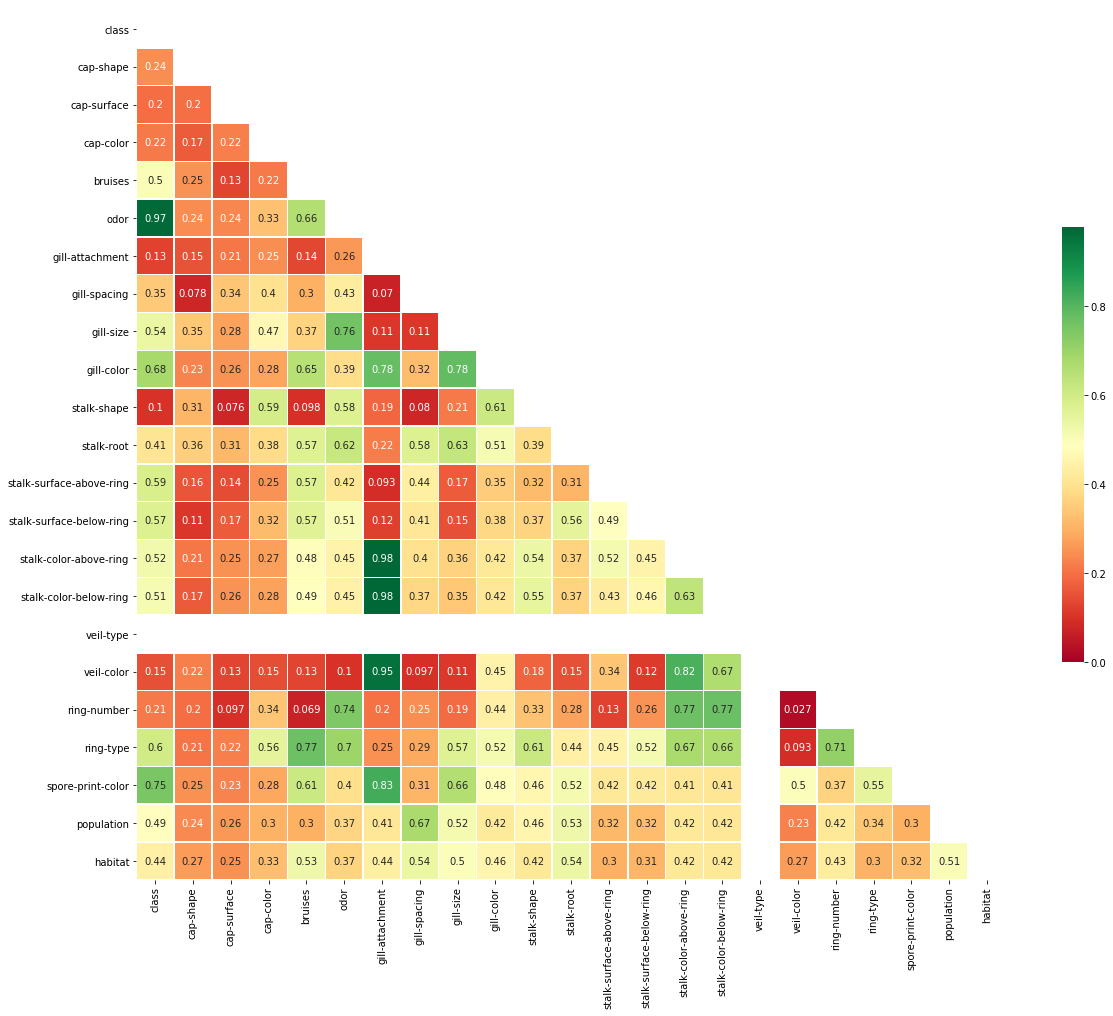

In [353]:
#association between nominal variables can be computed using Crammer's V
#https://pandas-profiling.github.io/pandas-profiling/docs/model/correlations.html

def cramers_corrected_stat(confusion_matrix):
    chi2, _, _, _ = scipy.stats.chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

cols = list(shroomdata.columns.values)
corrM = np.zeros((len(cols),len(cols)))

# Calculate correlations of every combination of variables
for col1, col2 in itertools.combinations(cols, 2):

    A, B = shroomdata[col1], shroomdata[col2]
    
    idx1, idx2 = cols.index(col1), cols.index(col2)
    dfObserved = pd.crosstab(A,B) 
    corrM[idx1, idx2] = cramers_corrected_stat(dfObserved.values)
    corrM[idx2, idx1] = corrM[idx1, idx2]

corr = pd.DataFrame(corrM, index=cols, columns=cols)

# Mask to get lower triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

cmap = sns.cubehelix_palette(light=1, as_cmap=True)

# Draw the heatmap with the mask 
fig = plt.figure(figsize=(20, 16))
sns.heatmap(corr, mask=mask, cmap="RdYlGn", square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.savefig("cramer.png", bbox_inches="tight", pad_inches=0, format="png", dpi=600)
plt.show()

### Checking the class distribution

e    4208
p    3916
Name: class, dtype: int64

e    0.517971
p    0.482029
Name: class, dtype: float64

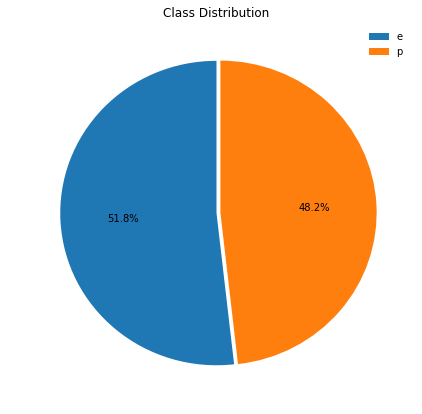

In [354]:
display(shroomdata['class'].value_counts())
display(shroomdata['class'].value_counts()/shroomdata['class'].count())

shroomdata.groupby('class').count().iloc[:,0].plot(kind='pie', startangle = 90, 
                                               autopct='%1.1f%%', figsize=(7,7),
                                               explode = (0, 0.025), labels = ['',''])
plt.axis('off')
plt.legend(['e','p'],loc=1, frameon=False)
plt.title('Class Distribution')
plt.show()

In [355]:
shroomdata.isnull().sum()

class                       0
cap-shape                   0
cap-surface                 0
cap-color                   0
bruises                     0
odor                        0
gill-attachment             0
gill-spacing                0
gill-size                   0
gill-color                  0
stalk-shape                 0
stalk-root                  0
stalk-surface-above-ring    0
stalk-surface-below-ring    0
stalk-color-above-ring      0
stalk-color-below-ring      0
veil-type                   0
veil-color                  0
ring-number                 0
ring-type                   0
spore-print-color           0
population                  0
habitat                     0
dtype: int64

In [356]:
for col in shroomdata.columns:
    print(col, '(',len(shroomdata[col].unique()),' values ) -->', shroomdata[col].unique())
    if col == 'class':
        intTotal = 1
    elif len(shroomdata[col].unique()) > 1:
        intTotal = intTotal*(len(shroomdata[col].unique())-1)   

class ( 2  values ) --> ['p' 'e']
cap-shape ( 6  values ) --> ['x' 'b' 's' 'f' 'k' 'c']
cap-surface ( 4  values ) --> ['s' 'y' 'f' 'g']
cap-color ( 10  values ) --> ['n' 'y' 'w' 'g' 'e' 'p' 'b' 'u' 'c' 'r']
bruises ( 2  values ) --> ['t' 'f']
odor ( 9  values ) --> ['p' 'a' 'l' 'n' 'f' 'c' 'y' 's' 'm']
gill-attachment ( 2  values ) --> ['f' 'a']
gill-spacing ( 2  values ) --> ['c' 'w']
gill-size ( 2  values ) --> ['n' 'b']
gill-color ( 12  values ) --> ['k' 'n' 'g' 'p' 'w' 'h' 'u' 'e' 'b' 'r' 'y' 'o']
stalk-shape ( 2  values ) --> ['e' 't']
stalk-root ( 5  values ) --> ['e' 'c' 'b' 'r' '?']
stalk-surface-above-ring ( 4  values ) --> ['s' 'f' 'k' 'y']
stalk-surface-below-ring ( 4  values ) --> ['s' 'f' 'y' 'k']
stalk-color-above-ring ( 9  values ) --> ['w' 'g' 'p' 'n' 'b' 'e' 'o' 'c' 'y']
stalk-color-below-ring ( 9  values ) --> ['w' 'p' 'g' 'b' 'n' 'e' 'y' 'o' 'c']
veil-type ( 1  values ) --> ['p']
veil-color ( 4  values ) --> ['w' 'n' 'o' 'y']
ring-number ( 3  values ) --> ['o' 't' 'n

<font color=green>Although there's no null value from our checking, it can be seen from tabulating the unique values for each attribute above that there are missing values denoted as "?". We could also notice that veil-type has only one value so we could drop this attribute.</font>

# <font color=red>Exploratory Data Analysis</font>

In [357]:
#drop the veil-type attribute
shroomdata = shroomdata.drop(["veil-type"], axis=1)

### Handling missing data

In [358]:
#showing the number of "?" values in stalk-root attribute
shroomdata = shroomdata.replace({'?':np.NaN})
shroomdata.isnull().sum()

class                          0
cap-shape                      0
cap-surface                    0
cap-color                      0
bruises                        0
odor                           0
gill-attachment                0
gill-spacing                   0
gill-size                      0
gill-color                     0
stalk-shape                    0
stalk-root                  2480
stalk-surface-above-ring       0
stalk-surface-below-ring       0
stalk-color-above-ring         0
stalk-color-below-ring         0
veil-color                     0
ring-number                    0
ring-type                      0
spore-print-color              0
population                     0
habitat                        0
dtype: int64

In [359]:
#replace the "?" value to n = unidentified
shroomdata['stalk-root'] = shroomdata['stalk-root'].replace(np.NaN,'n')
display(shroomdata['stalk-root'].value_counts())

b    3776
n    2480
e    1120
c     556
r     192
Name: stalk-root, dtype: int64

## Decision Tree Classifier (Label Encode)

In [361]:
#converting the categorical data to numerical
for col in shroomdata.columns:
    shroomdata[col] = labelencoder.fit_transform(shroomdata[col])
 
display(shroomdata.sample(n=10))

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
7355,1,2,3,4,0,7,1,0,1,0,...,2,1,6,7,2,1,0,7,4,2
2884,0,2,0,2,1,5,1,0,0,9,...,2,2,6,6,2,1,4,2,4,0
101,0,0,2,9,1,3,1,0,0,5,...,2,2,7,7,2,1,4,2,2,1
199,0,2,2,8,1,0,1,1,1,5,...,2,2,7,7,2,1,4,3,4,0
3203,0,2,0,2,1,5,1,0,0,7,...,2,2,6,7,2,1,4,2,4,0
6212,1,5,3,2,0,2,1,0,1,0,...,2,1,6,7,2,1,0,7,4,4
3183,0,2,0,2,1,5,1,0,0,10,...,2,2,3,7,2,1,4,3,5,0
7082,1,5,3,2,0,2,1,0,1,0,...,2,1,7,7,2,1,0,7,4,0
2830,0,5,3,2,1,5,1,0,0,10,...,2,2,7,6,2,1,4,2,4,0
4641,1,2,2,8,1,2,1,0,0,10,...,2,0,7,7,2,1,4,1,3,5


0    4208
1    3916
Name: class, dtype: int64

0    0.517971
1    0.482029
Name: class, dtype: float64

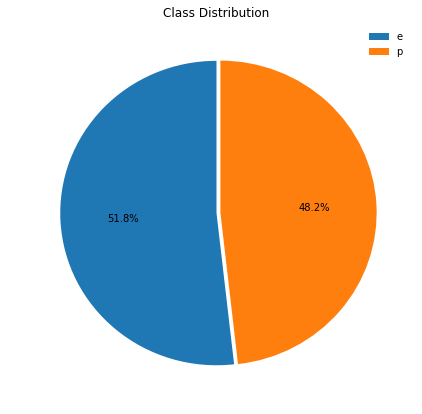

In [362]:
display(shroomdata['class'].value_counts())
display(shroomdata['class'].value_counts()/shroomdata['class'].count())

shroomdata.groupby('class').count().iloc[:,0].plot(kind='pie', startangle = 90, 
                                               autopct='%1.1f%%', figsize=(7,7),
                                               explode = (0, 0.025), labels = ['',''])
plt.axis('off')
plt.legend(['e','p'],loc=1, frameon=False)
plt.title('Class Distribution')
plt.show()

<font color=green>Edible, e = 0 <br>Poisonous, p = 1</font>

In [363]:
#Decision Tree classifier

X = shroomdata.iloc[:,1:22] #independent columns
y = shroomdata.iloc[:,0:1]  #target column

# split the data into training set and test set
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=0)

num_training = y_train.shape[0]
num_test = y_test.shape[0]
print('training: ' + str(num_training) + ', test: ' + str(num_test))

training: 5686, test: 2438


Decision Tree Classifier Max Depth: 7


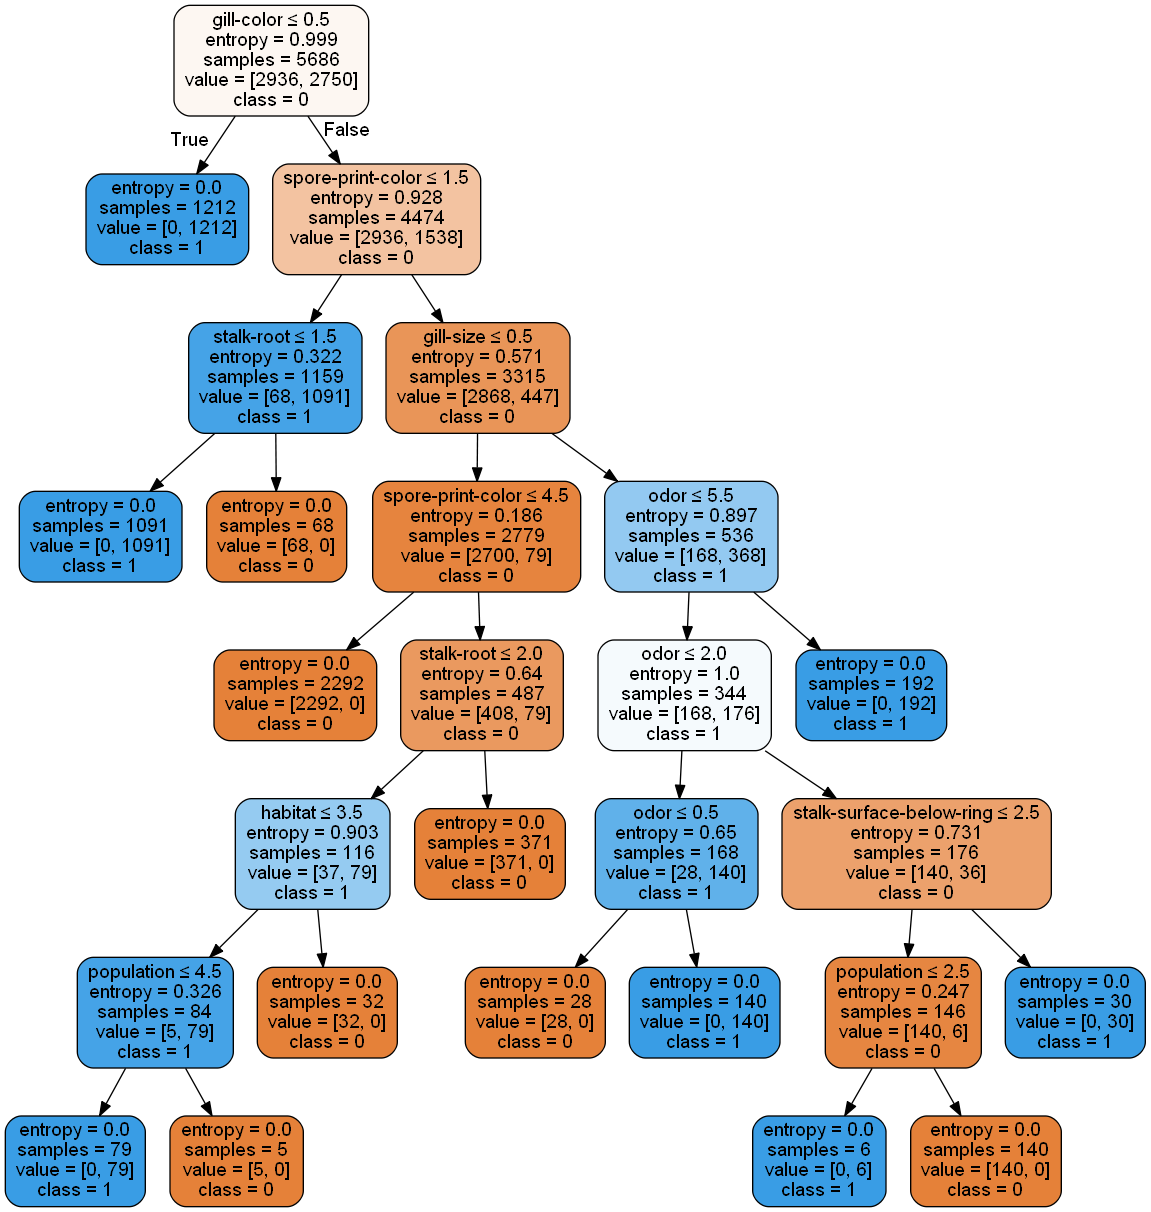

In [365]:
# input the decision tree classifier using "entropy" & train the model
dtree = DecisionTreeClassifier(criterion = 'entropy').fit(x_train, y_train)
# predict the classes of new, unseen data
dt_predict = dtree.predict(x_test)

print('Decision Tree Classifier Max Depth: {}'.format(dtree.tree_.max_depth))
dot_data = StringIO()
export_graphviz(dtree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = X.columns,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('dtree_default.png')
Image(graph.create_png())

In [366]:
for col in shroomdata.columns:
    print(col, '(',len(shroomdata[col].unique()),' values ) -->', shroomdata[col].unique())
    if col == 'class':
        intTotal = 1
    elif len(shroomdata[col].unique()) > 1:
        intTotal = intTotal*(len(shroomdata[col].unique())-1)   

class ( 2  values ) --> [1 0]
cap-shape ( 6  values ) --> [5 0 4 2 3 1]
cap-surface ( 4  values ) --> [2 3 0 1]
cap-color ( 10  values ) --> [4 9 8 3 2 5 0 7 1 6]
bruises ( 2  values ) --> [1 0]
odor ( 9  values ) --> [6 0 3 5 2 1 8 7 4]
gill-attachment ( 2  values ) --> [1 0]
gill-spacing ( 2  values ) --> [0 1]
gill-size ( 2  values ) --> [1 0]
gill-color ( 12  values ) --> [ 4  5  2  7 10  3  9  1  0  8 11  6]
stalk-shape ( 2  values ) --> [0 1]
stalk-root ( 5  values ) --> [2 1 0 4 3]
stalk-surface-above-ring ( 4  values ) --> [2 0 1 3]
stalk-surface-below-ring ( 4  values ) --> [2 0 3 1]
stalk-color-above-ring ( 9  values ) --> [7 3 6 4 0 2 5 1 8]
stalk-color-below-ring ( 9  values ) --> [7 6 3 0 4 2 8 5 1]
veil-color ( 4  values ) --> [2 0 1 3]
ring-number ( 3  values ) --> [1 2 0]
ring-type ( 5  values ) --> [4 0 2 1 3]
spore-print-color ( 9  values ) --> [2 3 6 1 7 5 4 8 0]
population ( 6  values ) --> [3 2 0 4 5 1]
habitat ( 7  values ) --> [5 1 3 0 4 6 2]


           Decision Tree Classifier Classification Report 
          
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      1272
          1       1.00      1.00      1.00      1166

avg / total       1.00      1.00      1.00      2438



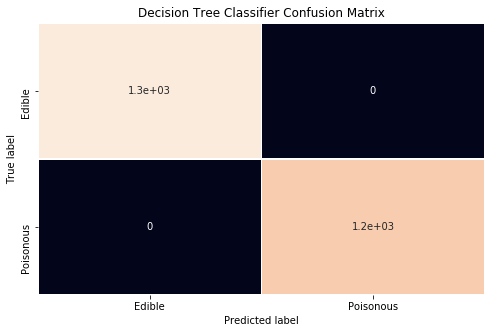

Accuracy: 1.00


In [367]:
print("Decision Tree Classifier Classification Report \n".center(69)) 
print(classification_report(y_test, dt_predict))

cm1=confusion_matrix(y_test, dt_predict)
cm_dt = pd.DataFrame(cm1, index =['Edible','Poisonous'], columns = ['Edible','Poisonous'])
plt.figure(figsize=(8,5))
sns.heatmap(cm_dt, annot = True,  linewidths=.5, cbar =None)
plt.title('Decision Tree Classifier Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print('Accuracy: %.2f' % accuracy_score(y_test, dt_predict))

In [368]:
#10 k-fold cross-validation
kfDT = KFold(len(X),n_folds=10)
results_kfoldDT = cross_val_score(dtree, X, y, cv=kf)
print("Average k-fold accuracy: %.2f" % (results_kfoldDT.mean())) 

Average k-fold accuracy: 1.00


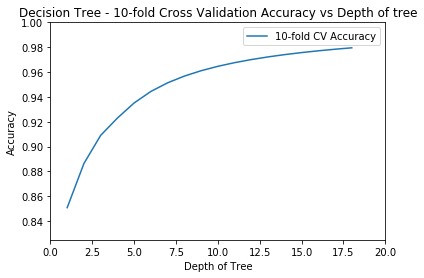

In [369]:
#10 cv vs. depth of tree graph
def computeCVAccuracy(X,y,folds):
    accuracy=[]
    foldAcc=[]
    depth=range(1,20)
    for i in depth: 
        kf = KFold(len(X),n_folds=folds)
        for train_index, test_index in kf:
            x_train,x_test,y_train,y_test = train_test_split(X,y, test_size = 0.3)
            dtree = DecisionTreeClassifier(max_depth = i).fit(x_train, y_train)
            score=dtree.score(x_test, y_test)
            accuracy.append(score)     
        foldAcc.append(np.mean(accuracy))  
    return(foldAcc)
    
    
cvAccuracy=computeCVAccuracy(X,y,folds=10)

df1=pd.DataFrame(cvAccuracy)
df1.columns=['10-fold CV Accuracy']
df=df1.reindex(range(1,20))
df.plot()
plt.title("Decision Tree - 10-fold Cross Validation Accuracy vs Depth of tree")
plt.xlabel("Depth of Tree")
plt.ylabel("Accuracy")
plt.ylim([0.825,1])
plt.xlim([0,20])
plt.savefig("dtree_cv_default.png", bbox_inches="tight", pad_inches=0, format="png", dpi=600)

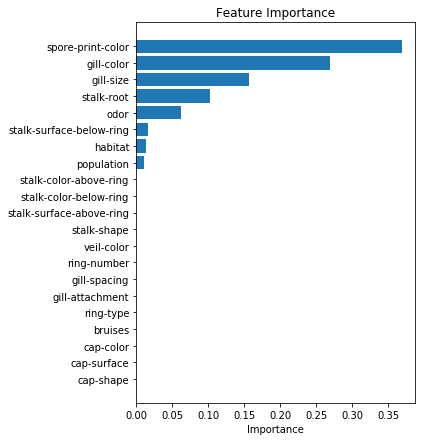

In [370]:
#feature importance graph
features_list = X.columns.values
feature_importance = dtree.feature_importances_
sorted_idx = np.argsort(feature_importance)

plt.figure(figsize=(5,7))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), features_list[sorted_idx])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.draw()
plt.savefig("dtree_fi_default.png", bbox_inches="tight", pad_inches=0, format="png", dpi=600)
plt.show()

## Decision Tree Classifier (One-hot Encode) 1st Iteration

In [391]:
shroomdata_dt = pd.read_csv('mushrooms.csv')
shroomdata_dt = shroomdata_dt.drop(["veil-type"], axis=1)

#showing the number of "?" values in stalk-root attribute
shroomdata_dt = shroomdata_dt.replace({'?':np.NaN})

#replace the "?" value to n = unidentified
shroomdata_dt['stalk-root'] = shroomdata_dt['stalk-root'].replace(np.NaN,'n')

shroomdata_dt = pd.get_dummies(shroomdata_dt)
shroomdata_dt.head(10)

,class_e,class_p,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_f,cap-surface_g,...,population_s,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
0,0,1,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0
1,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,1,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0
4,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
5,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
6,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
7,1,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
8,0,1,0,0,0,0,0,1,0,0,...,0,1,0,0,1,0,0,0,0,0
9,1,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0


In [392]:
#Decision Tree classifier

X = shroomdata_dt.iloc[:,2:119] #independent columns
y = shroomdata_dt.iloc[:,1:2]    #target column

# split the data into training set and test set
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=0)

num_training = y_train.shape[0]
num_test = y_test.shape[0]
print('training: ' + str(num_training) + ', test: ' + str(num_test))

training: 5686, test: 2438


Decision Tree Classifier Max Depth: 6


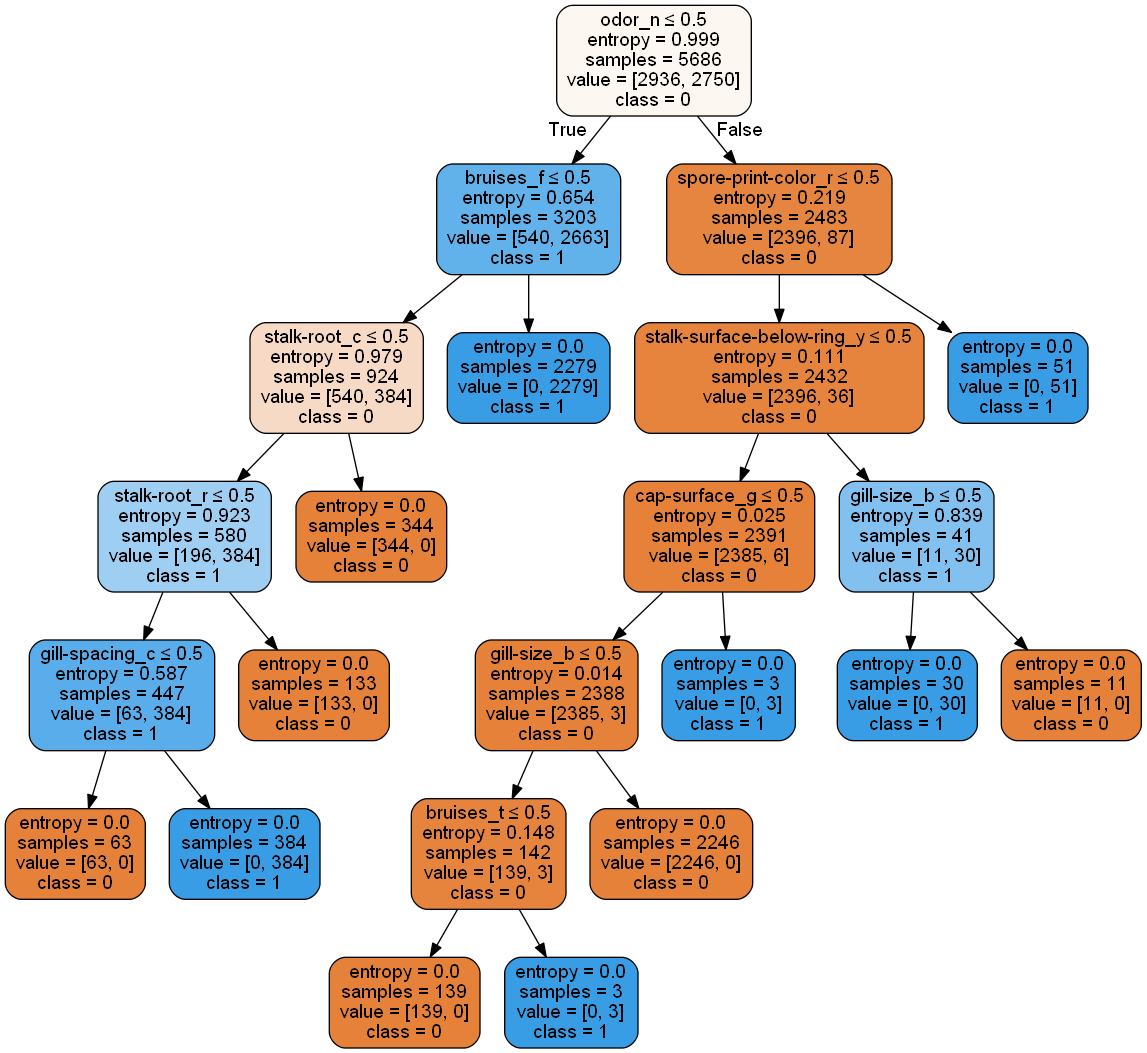

In [393]:
# input the decision tree classifier using "entropy" & train the model
dtree = DecisionTreeClassifier(criterion = 'entropy').fit(x_train, y_train)
# predict the classes of new, unseen data
dt_predict = dtree.predict(x_test)

dot_data = StringIO()
export_graphviz(dtree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = X.columns,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('dtree_ohe_1st.png')
Image(graph.create_png())

           Decision Tree Classifier Classification Report 
          
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      1272
          1       1.00      1.00      1.00      1166

avg / total       1.00      1.00      1.00      2438



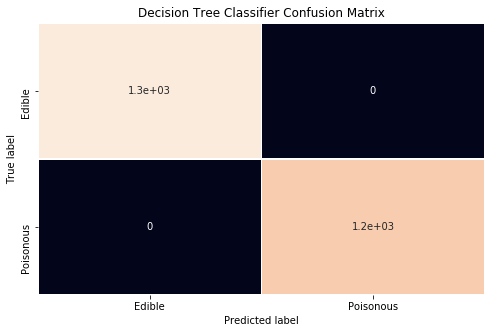

Accuracy: 1.00


In [394]:
print("Decision Tree Classifier Classification Report \n".center(69)) 
print(classification_report(y_test, dt_predict))

cm1=confusion_matrix(y_test, dt_predict)
cm_dt = pd.DataFrame(cm1, index =['Edible','Poisonous'], columns = ['Edible','Poisonous'])
plt.figure(figsize=(8,5))
sns.heatmap(cm_dt, annot = True,  linewidths=.5, cbar =None)
plt.title('Decision Tree Classifier Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print('Accuracy: %.2f' % accuracy_score(y_test, dt_predict))

In [395]:
#10 k-fold cross-validation
kfDT = KFold(len(X),n_folds=10)
results_kfoldDT = cross_val_score(dtree, X, y, cv=kf)
print("Average k-fold accuracy: %.2f" % (results_kfoldDT.mean())) 

Average k-fold accuracy: 1.00


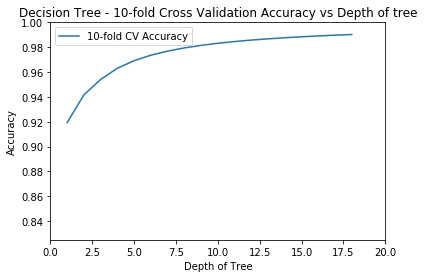

In [396]:
#10 cv vs. depth of tree graph
def computeCVAccuracy(X,y,folds):
    accuracy=[]
    foldAcc=[]
    depth=range(1,20)
    for i in depth: 
        kf = KFold(len(X),n_folds=folds)
        for train_index, test_index in kf:
            x_train,x_test,y_train,y_test = train_test_split(X,y, test_size = 0.3)
            dtree = DecisionTreeClassifier(max_depth = i).fit(x_train, y_train)
            score=dtree.score(x_test, y_test)
            accuracy.append(score)     
        foldAcc.append(np.mean(accuracy))  
    return(foldAcc)
    
    
cvAccuracy=computeCVAccuracy(X,y,folds=10)

df1=pd.DataFrame(cvAccuracy)
df1.columns=['10-fold CV Accuracy']
df=df1.reindex(range(1,20))
df.plot()
plt.title("Decision Tree - 10-fold Cross Validation Accuracy vs Depth of tree")
plt.xlabel("Depth of Tree")
plt.ylabel("Accuracy")
plt.ylim([0.825,1])
plt.xlim([0,20])
plt.savefig("dtree_cv_ohe_1st.png", bbox_inches="tight", pad_inches=0, format="png", dpi=600)

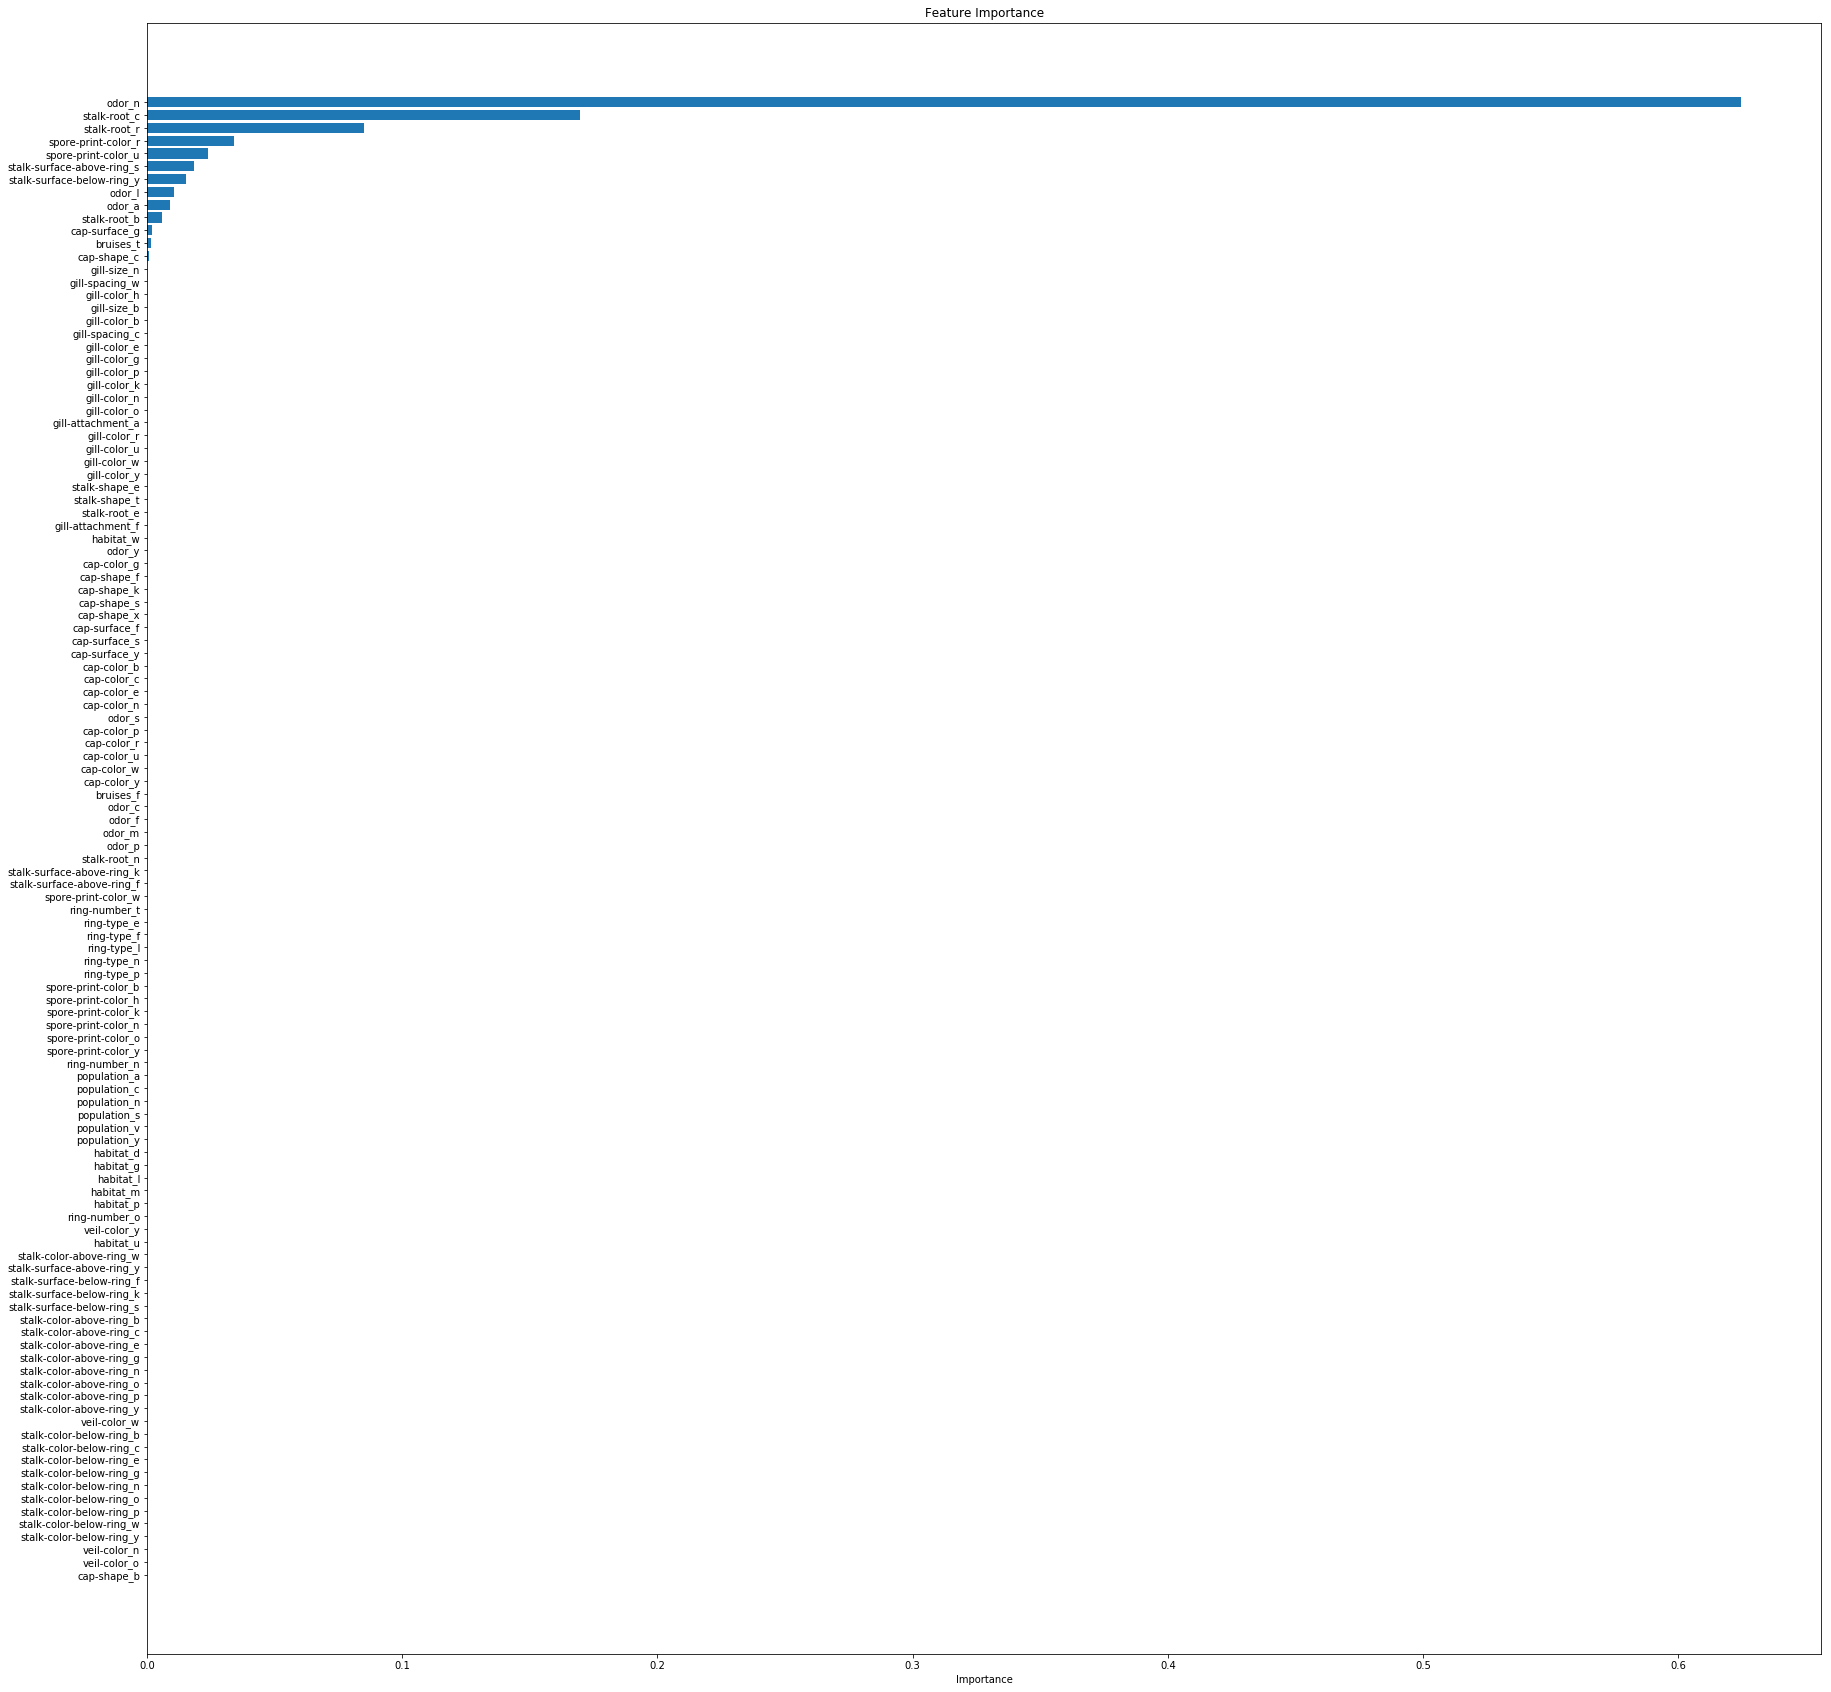

In [350]:
#feature importance graph
features_list = X.columns.values
feature_importance = dtree.feature_importances_
sorted_idx = np.argsort(feature_importance)

plt.figure(figsize=(30,30))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), features_list[sorted_idx])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.draw()
plt.savefig("dtree_fi_ohe_1st.png", bbox_inches="tight", pad_inches=0, format="png", dpi=600)
plt.show()

## Decision Tree Classifier (One-hot Encode) 2nd Iteration

Decision Tree Classifier Max Depth: 3


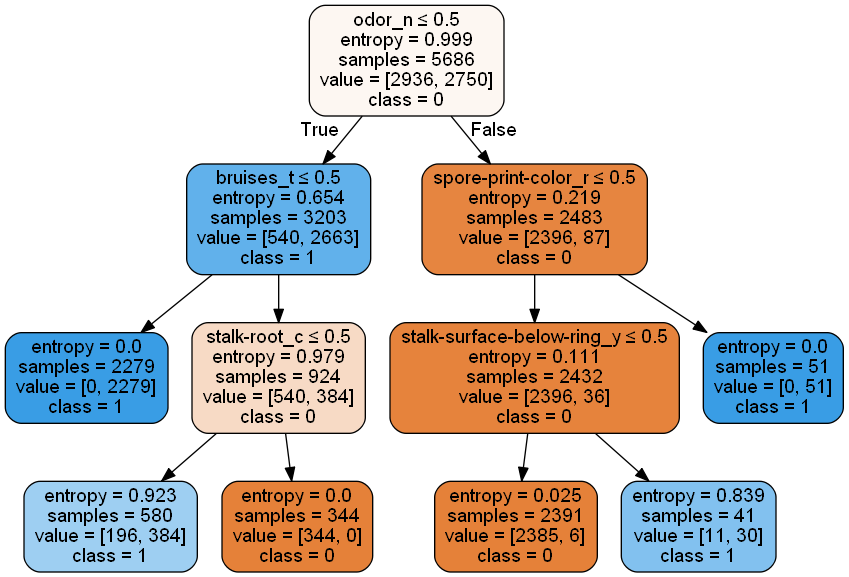

In [397]:
# input the decision tree classifier using "entropy" & train the model
dtree = DecisionTreeClassifier(criterion = 'entropy', min_samples_split=5, max_depth=3).fit(x_train, y_train)
# predict the classes of new, unseen data
dt_predict = dtree.predict(x_test)

print('Decision Tree Classifier Max Depth: {}'.format(dtree.tree_.max_depth))
dot_data = StringIO()
export_graphviz(dtree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = X.columns,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('dtree_ohe_2nd.png')
Image(graph.create_png())

           Decision Tree Classifier Classification Report 
          
             precision    recall  f1-score   support

          0       1.00      0.92      0.96      1272
          1       0.92      1.00      0.96      1166

avg / total       0.96      0.96      0.96      2438



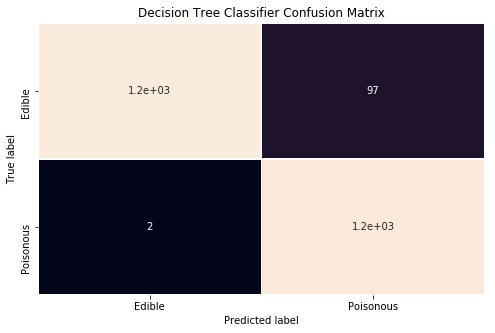

Accuracy: 0.96


In [398]:
print("Decision Tree Classifier Classification Report \n".center(69)) 
print(classification_report(y_test, dt_predict))

cm1=confusion_matrix(y_test, dt_predict)
cm_dt = pd.DataFrame(cm1, index =['Edible','Poisonous'], columns = ['Edible','Poisonous'])
plt.figure(figsize=(8,5))
sns.heatmap(cm_dt, annot = True,  linewidths=.5, cbar =None)
plt.title('Decision Tree Classifier Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print('Accuracy: %.2f' % accuracy_score(y_test, dt_predict))

In [399]:
kfDT = KFold(len(X),n_folds=10)
results_kfoldDT = cross_val_score(dtree, X, y, cv=kf)
print("Average k-fold accuracy: %.2f" % (results_kfoldDT.mean())) 

Average k-fold accuracy: 0.93


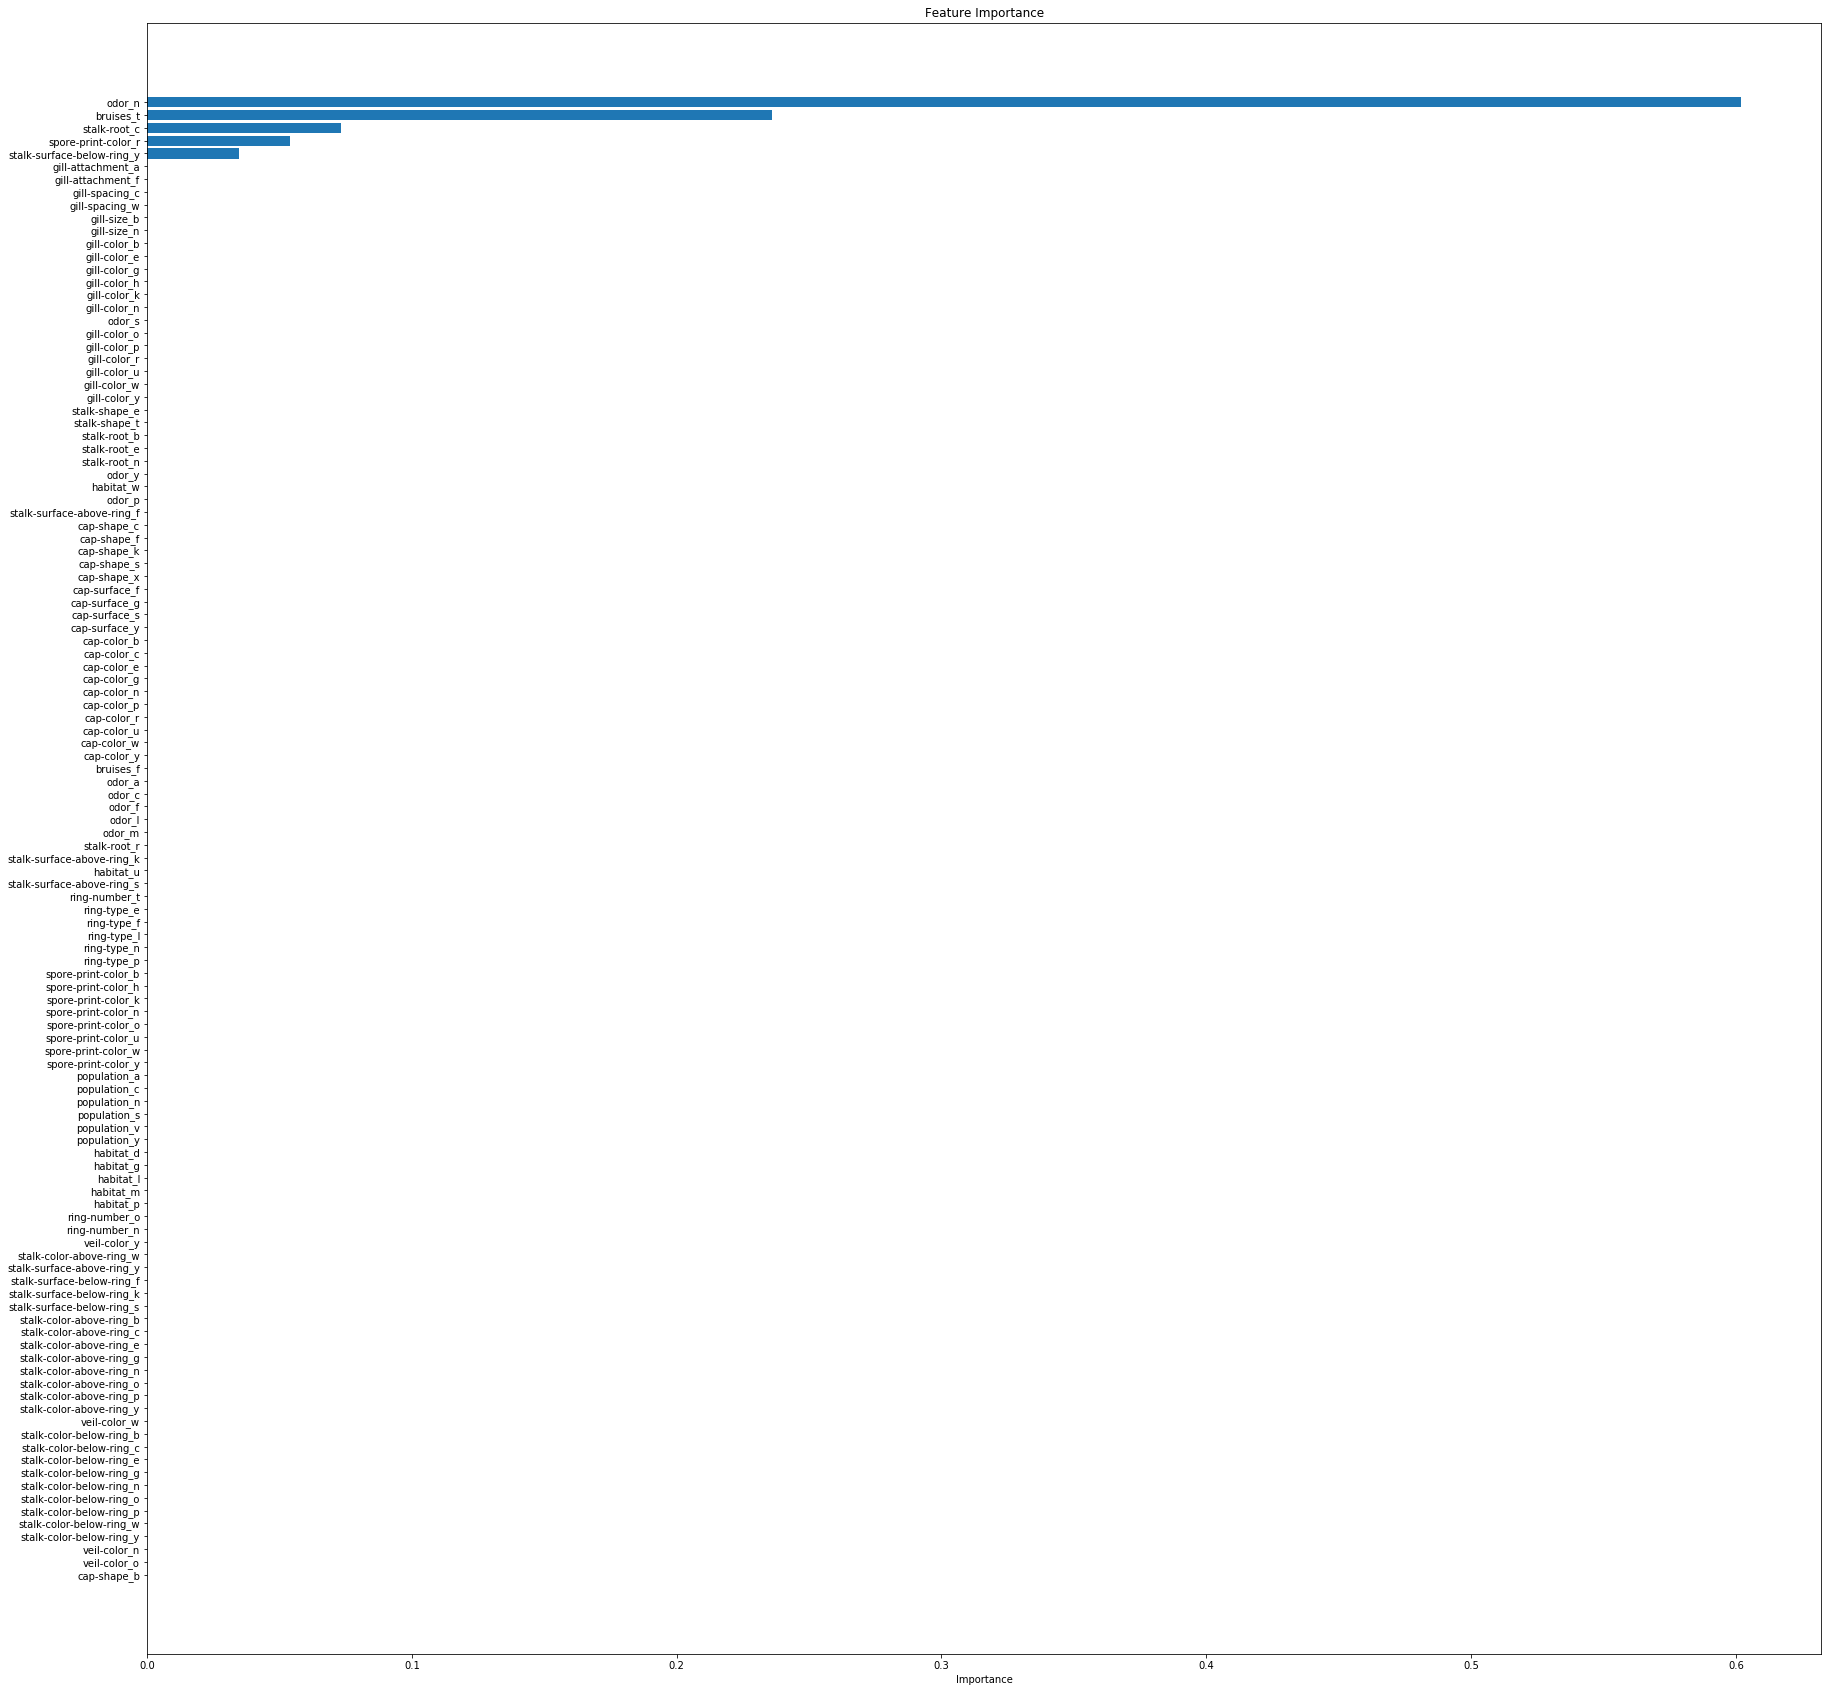

In [400]:
features_list = X.columns.values
feature_importance = dtree.feature_importances_
sorted_idx = np.argsort(feature_importance)

plt.figure(figsize=(30,30))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), features_list[sorted_idx]) 
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.savefig("dtree_fi_ohe_2nd.png", bbox_inches="tight", pad_inches=0, format="png", dpi=600)
plt.show()

## Naive Bayes Classifier (One Hot Encode)

In [360]:
#label encode on class
le = LabelEncoder()
shroomdata['class'] = le.fit_transform(shroomdata['class'])

#creating dummy data and one-hot encode on the values
shroomdata_he = pd.get_dummies(shroomdata)
shroomdata_he.sample(n=10)

,class,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_f,cap-surface_g,cap-surface_s,...,population_s,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
7460,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,1,0,0,0,0,0
7803,0,0,0,0,1,0,0,1,0,0,...,1,0,0,0,1,0,0,0,0,0
328,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2083,0,0,0,1,0,0,0,1,0,0,...,0,1,0,1,0,0,0,0,0,0
4890,1,0,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
4482,1,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,1,0,0
188,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2312,0,0,0,1,0,0,0,1,0,0,...,0,0,1,1,0,0,0,0,0,0
6740,1,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,1,0,0,0,0
2595,0,0,0,0,0,0,1,1,0,0,...,0,0,1,1,0,0,0,0,0,0


In [388]:
b = shroomdata_he.iloc[:,1:] #x
a = shroomdata_he.iloc[:,0] #y
b_train, b_test, a_train, a_test = train_test_split(b, a, test_size=0.3, random_state=0) # 0.3 means 30 pc of the data set to be test data

num_training = a_train.shape[0]
num_test = a_test.shape[0]
print('training: ' + str(num_training) + ', test: ' + str(num_test))

training: 5686, test: 2438


           Naive Bayes Classifier Classification Report 
          
             precision    recall  f1-score   support

          0       1.00      0.93      0.96      1272
          1       0.93      1.00      0.96      1166

avg / total       0.97      0.96      0.96      2438



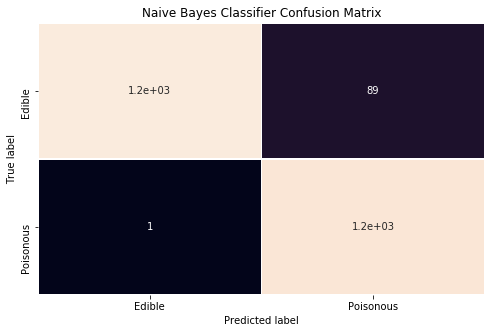

Misclassified samples: 90 out of 2438

Accuracy: 0.96


In [389]:
gnb = GaussianNB()
gnb.fit(b_train, a_train)
nb_predict = gnb.predict(b_test) 

print("Naive Bayes Classifier Classification Report \n".center(67))
print(classification_report(y_test, nb_predict))

cm2=confusion_matrix(a_test, nb_predict)
cm_nb = pd.DataFrame(cm2, index =['Edible','Poisonous'], columns = ['Edible','Poisonous'])
plt.figure(figsize=(8,5))
sns.heatmap(cm_nb, annot = True,  linewidths=.5, cbar =None)
plt.title('Naive Bayes Classifier Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print('Misclassified samples: %d out of %d\n' % ((a_test != nb_predict).sum(), a_test.shape[0]))
print('Accuracy: %.2f' % accuracy_score(a_test, nb_predict))

In [390]:
kfNA = KFold(len(b),n_folds=10)
results_kfoldNA = cross_val_score(gnb, b, a, cv=kfNA)
print("Average k-fold accuracy: %.2f" % (results_kfoldNA.mean())) 

Average k-fold accuracy: 0.94


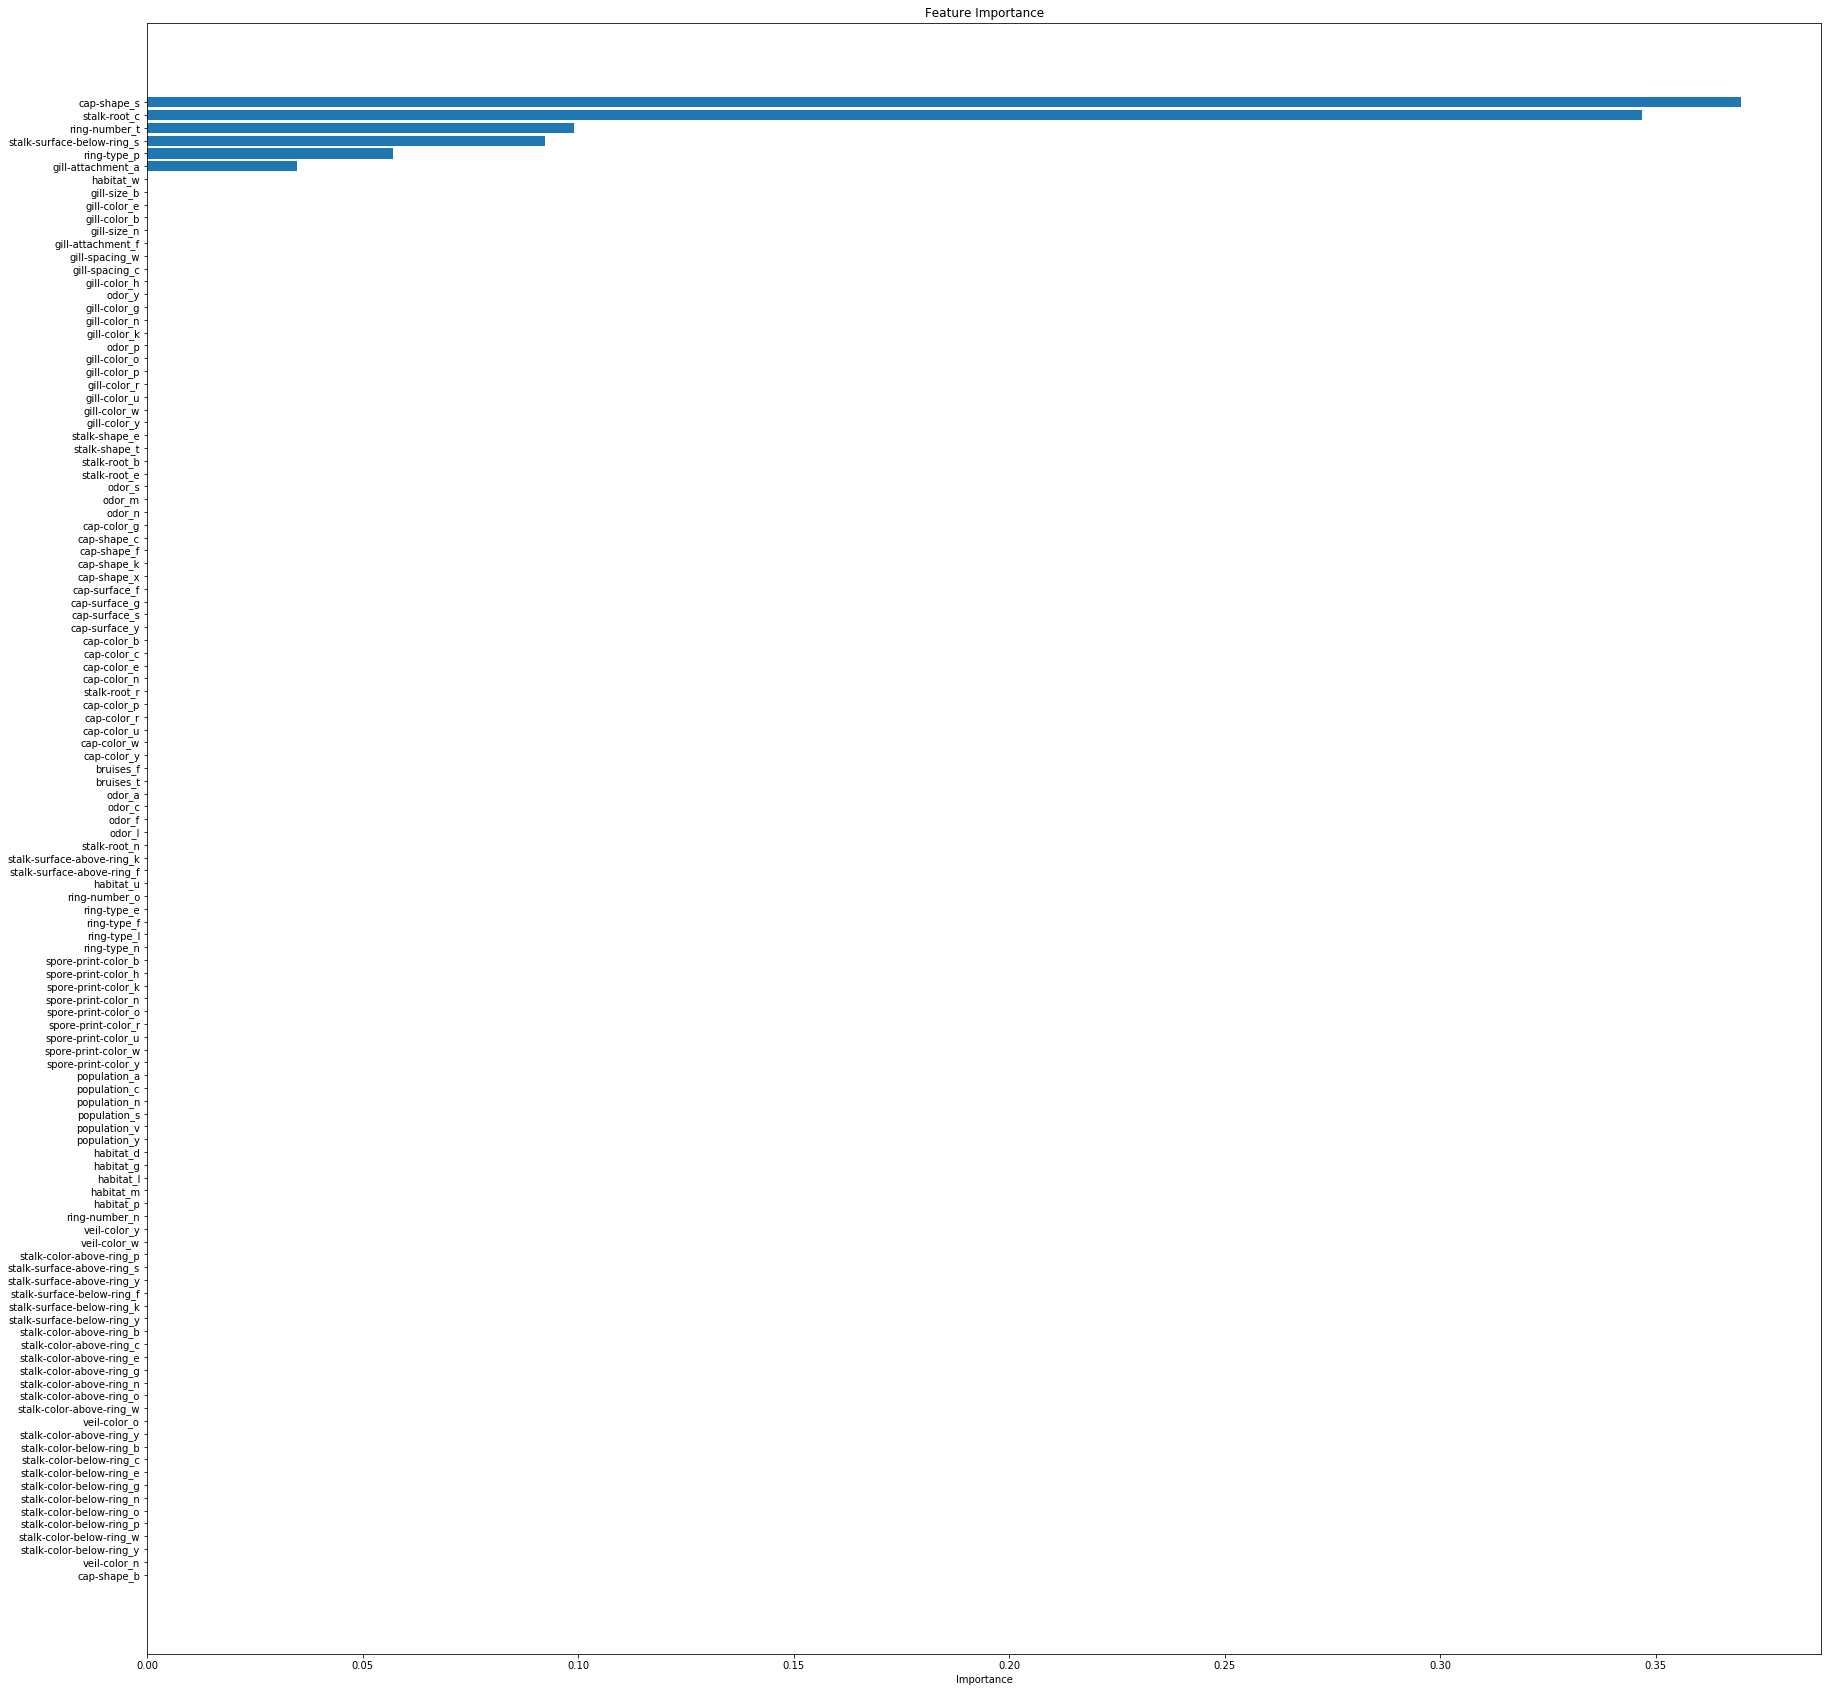

In [230]:
features_list = b.columns.values
feature_importance = dtree.feature_importances_
sorted_idx = np.argsort(feature_importance)

plt.figure(figsize=(30,30))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), features_list[sorted_idx])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.savefig("nb_ohe.png", bbox_inches="tight", pad_inches=0, format="png", dpi=600)
plt.show()

# UNUNSED FUNCTIONS. PLEASE IGNORE

In [401]:
# dot_data = export_graphviz(dtree, out_file=None, 
#                          feature_names=X.columns,  
#                          filled=True, rounded=True,  
#                          special_characters=True)  
# graph = graphviz.Source(dot_data)  
# display(graph) 

# #graph.write_png("dtree_default.png")

# #plt.savefig("dtree_default.png", bbox_inches="tight", pad_inches=0, format="png", dpi=600)
# print('Decision Tree Classifier Max Depth: {}'.format(dtree.tree_.max_depth))
# # import collections

# # from IPython.display import Image
# # #Image(filename = 'dtree_default.png')
# # graph.write_png('dtree_default.png')

# from subprocess import call
# call(['dot', '-Tpng', 'tree.dot', '-o', 'dtree_default.png', '-Gdpi=600'])

# # Display in jupyter notebook
# from IPython.display import Image
# Image(filename = 'dtree_default.png')

In [402]:
# # Import the DecisionTreeClassifier
# from sklearn.tree import DecisionTreeClassifier

# # input the decision tree classifier using "entropy" & train the model
# dtree = DecisionTreeClassifier(criterion = 'gini', min_samples_split=5, max_depth=3).fit(x_train, y_train)
# # predict the classes of new, unseen data
# dt_predict = dtree.predict(x_test)

# from sklearn.tree import DecisionTreeClassifier, export_graphviz
# import graphviz
# dot_data = export_graphviz(dtree, out_file=None, 
#                          feature_names=X.columns,  
#                          filled=True, rounded=True,  
#                          special_characters=True)  
# graph = graphviz.Source(dot_data)  
# graph 

In [404]:
# feature_columns = shroomdata.columns[1:]
# for i, f in zip(np.arange(1, len(feature_columns) + 1), feature_columns):
#     print('Feature {:d}:\t{}'.format(i, f))

In [403]:
# from sklearn.feature_selection import chi2, SelectKBest
# from sklearn.preprocessing import LabelEncoder

# le = LabelEncoder()
# numeric_data = pd.DataFrame()
# for f in feature_columns:
#     numeric_data[f] = le.fit_transform(shroomdata[f])
    
# chi_statics, p_values = chi2(numeric_data, shroomdata['class'])

# chi2_result = pd.DataFrame({'features': feature_columns, 'chi2_statics': chi_statics, 'p_values': p_values})
# chi2_result.dropna(axis=0, how='any', inplace=True)

# print(chi2_result.sort_values(by='chi2_statics', ascending=False)[['features', 'chi2_statics', 'p_values']].reset_index().drop('index', axis=1))

# _ = chi2_result.sort_values(by='chi2_statics', ascending=True).set_index('features')['chi2_statics'].plot(kind='barh', logx=True, rot=-2)

In [405]:
# df_all_corr = m_data.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
# df_all_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
# df_all_corr[df_all_corr['Feature 1'] == 'class']

In [193]:
# def cramers_v(x, y):
#     confusion_matrix = pd.crosstab(x,y)
#     chi2 = ss.chi2_contingency(confusion_matrix)[0]
#     n = confusion_matrix.sum().sum()
#     phi2 = chi2/n
#     r,k = confusion_matrix.shape
#     phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
#     rcorr = r-((r-1)**2)/(n-1)
#     kcorr = k-((k-1)**2)/(n-1)
#     return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [406]:
# def plot_data(hue, data):
#     for i, col in enumerate(shroomdata.columns):
#         plt.figure(i)
#         sns.set(rc={'figure.figsize':(11.7,8.27)})
#         ax = sns.countplot(x=data[col], hue=hue, data=shroomdata)
        
# hue = shroomdata['class']
# data_for_plot = shroomdata
# plot_data(hue, data_for_plot)

In [254]:
# #Using Pearson Correlation
# plt.figure(figsize=(20,16))
# cor = shroomdata.corr()
# #sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
# sns.heatmap(cor, annot=True, cmap="RdYlGn")
# plt.show()

# # data = pd.read_csv("D://Blogs//train.csv")
# # X = data.iloc[:,0:20]  #independent columns
# # y = data.iloc[:,-1]    #target column i.e price range
# # #get correlations of each features in dataset
# # corrmat = data.corr()
# # top_corr_features = corrmat.index
# # plt.figure(figsize=(20,20))
# # #plot heat map
# # g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [253]:
# #Correlation with output variable
# cor_target = abs(cor["class"])
# display(cor_target)
# #Selecting highly correlated features
# relevant_features = cor_target[cor_target>=0.1]
# display(relevant_features)

In [252]:
# num_feats=10
# def cor_selector(X, y,num_feats):
#     cor_list = []
#     feature_name = X.columns.tolist()
#     # calculate the correlation with y for each feature
#     for i in X.columns.tolist():
#         cor = np.corrcoef(X[i], y)[0, 1]
#         cor_list.append(cor)
#     # replace NaN with 0
#     cor_list = [0 if np.isnan(i) else i for i in cor_list]
#     # feature name
#     cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
#     # feature selection? 0 for not select, 1 for select
#     cor_support = [True if i in cor_feature else False for i in feature_name]
#     return cor_support, cor_feature
# cor_support, cor_feature = cor_selector(X, y,num_feats)
# print(str(len(cor_feature)), 'selected features')